In [1]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pose import *

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

sam_checkpoint = "../../models/sam2.1_hiera_large.pt"
model_cfg = "./configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam_checkpoint, device=device))
input_points = []
input_labels = []
images = []
masks_res = []

folder = "../../Data/Sample1"
refCamID = 0
numImage = 16
poses, pts3d, perms, w2c, c2w = load_colmap_data(folder)
cdepth, idepth = computecloseInfinity(poses, pts3d, perms)
close_depth = np.min(cdepth) * 0.9
inf_depth = np.max(idepth) * 2.0
focals = poses[2, 4, :]

for i in range(numImage):
    filename = folder + "/images/{:03d}.png".format(i)
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    input_points.append([])
    input_labels.append([])
    masks_res.append(None)

Cameras 5
['000.png', '001.png', '002.png', '004.png', '003.png', '006.png', '005.png', '012.png', '007.png', '014.png', '008.png', '009.png', '011.png', '010.png', '013.png', '015.png']
Images # 16


In [17]:
#add point
refCamID = 0
point = [840, 1356]
label = 1

predictor.set_image(images[refCamID])
masks, scores, logits = predictor.predict(point_coords=np.array([point]), point_labels=np.array([label]), multimask_output=False,)
                
print(logits.shape)
h, w = masks.shape[-2:]
mask_image = masks.reshape(h, w, 1)
coords = np.where(mask_image > 0.0)
boundingBox = int(np.min(coords[1])), int(np.max(coords[1])), int(np.min(coords[0])), int(np.max(coords[0]))
optZ, offsetX, offsetY = computeOffset(images, boundingBox, c2w, w2c, focals, 0, close_depth, inf_depth, perms)
for i in range(numImage):
    input_points[i].append([point[0] + offsetX[i], point[1] + offsetY[i]])
    input_labels[i].append(label)

(1, 256, 256)


In [19]:
for i in range(numImage):
    predictor.set_image(images[i])
    masks, scores, logits = predictor.predict(point_coords=np.array(input_points[i]), point_labels=np.array(input_labels[i]), multimask_output=False,)
    masks_res[i] = masks

NameError: name 'show_mask' is not defined

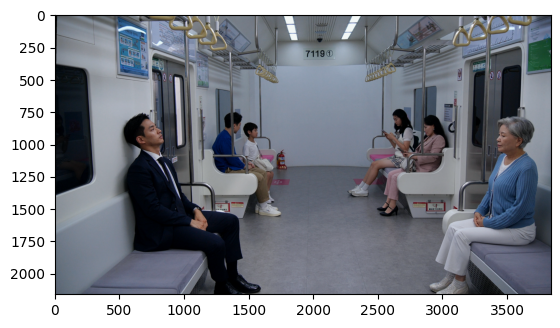

In [20]:
plt.imshow(images[0])
show_mask(masks_res[0], plt.gca())
show_points(np.array(input_points[0]), np.array(input_labels[0]), plt.gca())
plt.axis('on')
plt.show()